## Importing Libraries 

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import spacy
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from imblearn.under_sampling import NearMiss

# The dataset

In [2]:
# Loading the dataset
dataset_path = "Data\job_data.csv"
job_postings_data = pd.read_csv(dataset_path)
job_postings_data.head(5)


<>:2: SyntaxWarning: invalid escape sequence '\j'
<>:2: SyntaxWarning: invalid escape sequence '\j'
C:\Users\dobal\AppData\Local\Temp\ipykernel_27884\1425200355.py:2: SyntaxWarning: invalid escape sequence '\j'
  dataset_path = "Data\job_data.csv"


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Visualizing the data and details about it

Group by caterogies

In [6]:
employment_by_fraudulent = job_postings_data.groupby(['employment_type', 'fraudulent']).size().unstack()
has_company_logo_by_fraudulent = job_postings_data.groupby(['has_company_logo', 'fraudulent']).size().unstack()
required_experience_by_fraudulent = job_postings_data.groupby(['required_experience', 'fraudulent']).size().unstack()
fraudulent_counts = job_postings_data.groupby(['fraudulent', 'fraudulent']).size().unstack()

Plot for more insights of the dataset to provide clear informations about it and helps to state the problem.

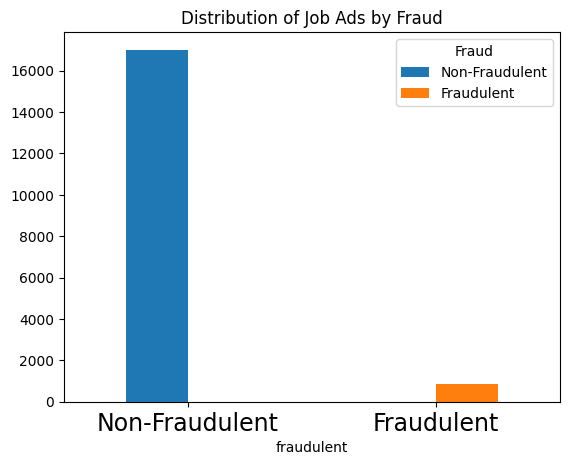

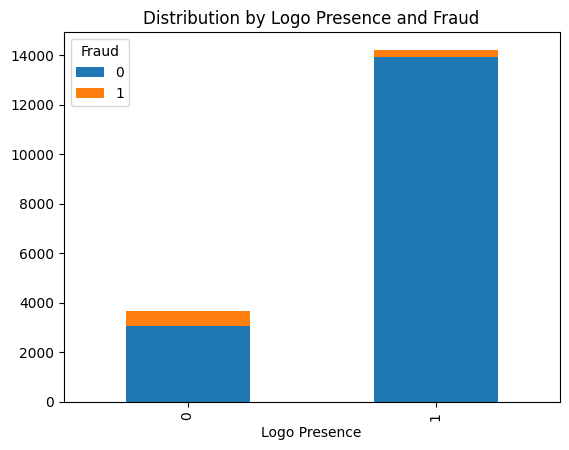

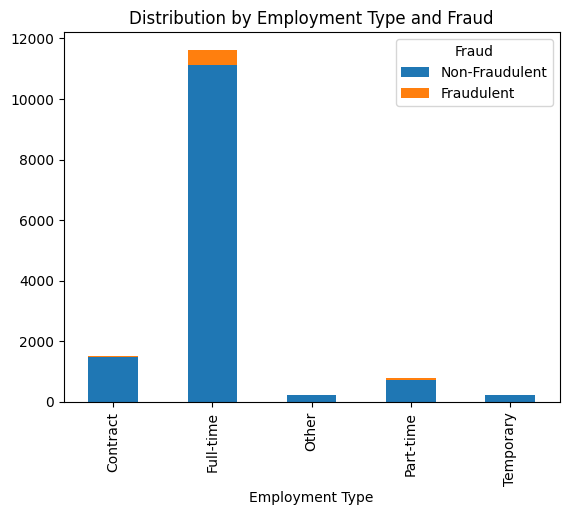

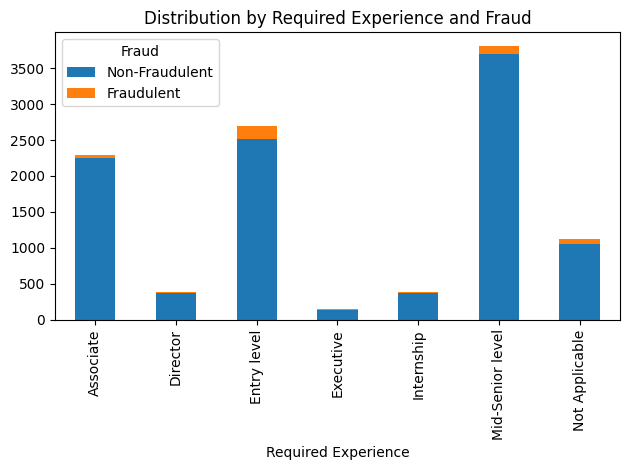

In [11]:
colors = ["#1f77b4", "#ff7f0e"]

fraudulent_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Job Ads by Fraud')
plt.xticks(rotation=0, labels=["Non-Fraudulent", "Fraudulent"], ticks=[0,1], fontsize=17)
plt.legend(title='Fraud', loc='upper right', labels=["Non-Fraudulent", 'Fraudulent'])
plt.show()

has_company_logo_by_fraudulent.plot(kind='bar', stacked=True, color=colors)
plt.title('Distribution by Logo Presence and Fraud')
plt.xlabel('Logo Presence')
plt.legend(title='Fraud', loc='upper left')
plt.show()

employment_by_fraudulent.plot(kind='bar', stacked=True, color=colors)
plt.title('Distribution by Employment Type and Fraud')
plt.xlabel('Employment Type')
plt.legend(title='Fraud', loc='upper right', labels=["Non-Fraudulent", 'Fraudulent'])
plt.show()

required_experience_by_fraudulent.plot(kind='bar', stacked=True, color=colors)
plt.title('Distribution by Required Experience and Fraud')
plt.xlabel('Required Experience')
plt.legend(title='Fraud', loc='upper left', labels=["Non-Fraudulent", 'Fraudulent'])
plt.tight_layout()  

plt.show()

From the graphs we looked at, we learned things about the job ads. First, we found out that most of the fake job ads are for full-time jobs. This makes sense because many people want full-time work. The second graph shows us that companies pretending to be real often don't have a logo. So, whether a job ad has a logo or not is a big clue if it's real or fake. The third graph tells us that fake jobs don't usually ask for people to be in very high jobs like a director. They mostly ask for people who are just starting or have a little bit of experience. The last graph shows that there are a lot more real job ads than fake ones more than 10 times more. To help with the fact that there are not many fake job ads to learn from, one thing we can do is called oversampling.

# Function for the code 

#### Tokenization function

In [43]:
#from lab1
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])
def clean_text(text):
    doc = nlp(text)
    tokens = [token for token in doc if not token.is_stop and token.is_alpha]
    lemmas = [token.lemma_ for token in tokens]
    return lemmas

#### Vectorizer regarding text data

In [44]:
#vectorizer
def create_word_vector(doc_texts, clean_up):
    word_counter = CountVectorizer(tokenizer=clean_up)
    word_matrix = word_counter.fit_transform(doc_texts)
    return(word_matrix, word_counter)


#### Function returning a bag of n words

In [45]:
#in order to compare Unfraudulent and fraudulent top words (more insights)
def find_top_words(X, word_counter, top_n):
    """Finds the top 'n' most common words in a dataset processed by a vectorizer.

    This function takes the output of a vectorizer and identifies the most frequent words in the text it was applied to. It uses the word counts to figure out which words appear the most.

    Args:
      word_counter: A vectorizer object that has already been fit to some text data.
      X: A matrix with the counts of every word in each document.
      top_n: How many of the top words to return.

    Returns:
      A pandas series with the 'n' most frequent words.
    """

    words = word_counter.get_feature_names_out()
    word_matrix_df = pd.DataFrame(X.toarray(), columns=words)
    word_freq = word_matrix_df.sum(axis=0)
    top_words = word_freq.nlargest(top_n)
    return top_words


#### ROC curve and ROC score display

In [46]:
def display_roc_curve(actual_values, model_predictions, model_label):
    """Displays the Receiver Operating Characteristic (ROC) curve and ROC score for a given classifier.

    This function takes the true outcomes and the predicted probabilities from a classifier, then generates and displays the ROC curve. It also calculates and shows the Area Under the Curve (AUC) score, which is a performance measurement for the classification model at various threshold settings.

    Args:
      actual_values (array): The true labels of the dataset.
      model_predictions (array): The probability estimates provided by the classifier.
      model_label (str): A name for the classifier to display on the plot.

    """
    fpr, tpr, _ = metrics.roc_curve(actual_values, model_predictions)
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_label)
    roc_display.plot()
    plt.show()


## Last insight about the data before processing ML algorithms with Different undersampling/oversampling methods.

In [47]:
# Separating job descriptions into fraudulent and non-fraudulent categories
mask = job_postings_data['fraudulent'] == 0  
real_job_descriptions = job_postings_data[mask]["description"]  
fake_job_descriptions = job_postings_data[~mask]["description"]  
X_real, real_vectorizer = create_word_vector(real_job_descriptions, clean_text)

top_n = 10  # We're interested in the top 10 most common words to have quick sample of the most used words
print(find_top_words(X_real, real_vectorizer, top_n))

#doing the same for the fake job descriptions
X_fake, fake_vectorizer = create_word_vector(fake_job_descriptions.values.astype('U'), clean_text)
print(find_top_words(X_fake, fake_vectorizer, top_n))


c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


team          19671
work          19584
customer      14367
service       12002
business      11109
company       11083
client        11002
product       10993
experience    10353
new            9474
dtype: int64


c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


work        1167
service      763
customer     680
project      607
amp          596
product      591
position     578
team         552
company      550
time         504
dtype: int64


We've noticed that our dataset has a lot more real job ads than fake ones, making it unbalanced. Also, it's hard to tell the fake job descriptions apart just by looking at the most common words we found. We're going to test some different ways to see if we can better identify fake ads without making changes to the number of examples we have. These initial tests will help us set a starting point. Later, we'll explore methods to balance our data, like adding more examples of the less common type (oversampling) or reducing the examples of the more common type (undersampling), to see if these techniques help us do a better job. We'll use the ROC score, which is good for this kind of yes-or-no problem, to see how well each method works

#### Spliting dataset and make a vectorizer according to the training data (80% of the dataset)

In [48]:
X = job_postings_data.drop('fraudulent', axis=1)
y = job_postings_data['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
_, training_vectorizer = create_word_vector(X_train['description'].values.astype('U'), clean_text)

c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Using ML algorithms on the data

## Baseline models

#### Naive Bayes Classifier - BASELINE

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3395
           1       0.74      0.18      0.29       181

    accuracy                           0.96      3576
   macro avg       0.85      0.59      0.63      3576
weighted avg       0.95      0.96      0.94      3576



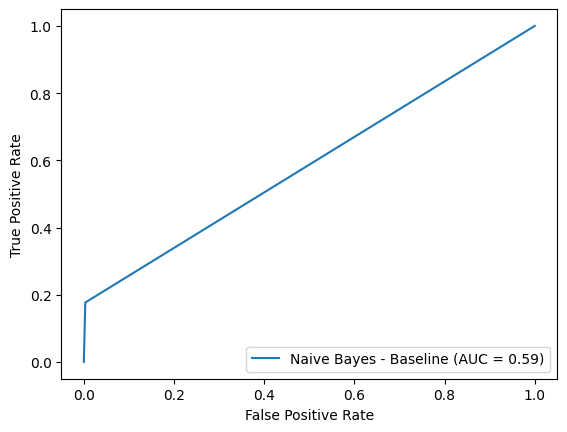

In [49]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('vectorize', training_vectorizer),  
    ('classifier', BernoulliNB()) 
])


pipeline.fit(X_train['description'].values.astype('U'), y_train)

# Predict the outcomes for the test set descriptions
predictions = pipeline.predict(X_test['description'].values.astype('U'))
print(classification_report(y_test, predictions))
display_roc_curve(y_test, predictions, "Naive Bayes - Baseline")

#### Logistic Regression - BASELINE

c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3395
           1       0.83      0.60      0.70       181

    accuracy                           0.97      3576
   macro avg       0.91      0.80      0.84      3576
weighted avg       0.97      0.97      0.97      3576



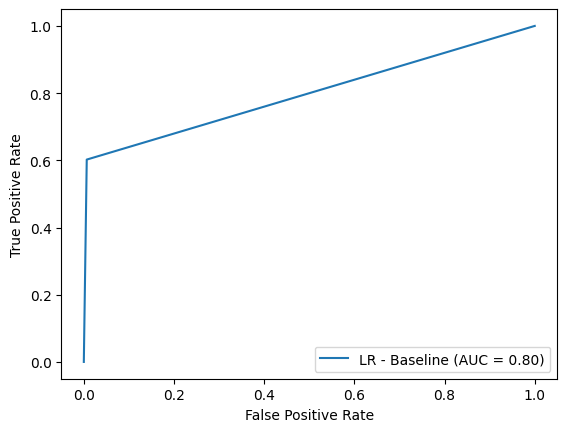

In [50]:
from sklearn.linear_model import LogisticRegression


pipeline = Pipeline([
    ('vectorize', training_vectorizer),  
    ('classifier', LogisticRegression())  
])

pipeline.fit(X_train['description'].values.astype('U'), y_train)
logreg_pred = pipeline.predict(X_test['description'].values.astype('U'))
print(classification_report(y_test, logreg_pred))
display_roc_curve(y_test, logreg_pred, "LR - Baseline")


#### Decision Trees - BASELINE

c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3395
           1       0.77      0.62      0.69       181

    accuracy                           0.97      3576
   macro avg       0.88      0.81      0.84      3576
weighted avg       0.97      0.97      0.97      3576



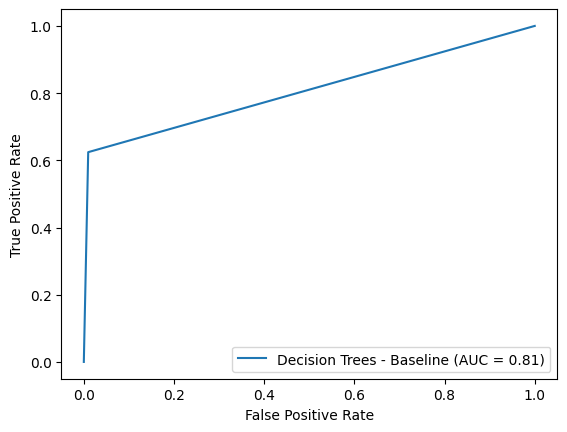

In [51]:
from sklearn import tree

pipeline = Pipeline([
    ('vectorize', training_vectorizer),  
    ('classifier', tree.DecisionTreeClassifier())  
])

pipeline.fit(X_train['description'].values.astype('U'), y_train)
dectrees_pred = pipeline.predict(X_test['description'].values.astype('U'))
print(classification_report(y_test, dectrees_pred))
display_roc_curve(y_test, dectrees_pred, "Decision Trees - Baseline")


#### Support Vector Machine - BASELINE

c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3395
           1       0.76      0.64      0.69       181

    accuracy                           0.97      3576
   macro avg       0.87      0.81      0.84      3576
weighted avg       0.97      0.97      0.97      3576



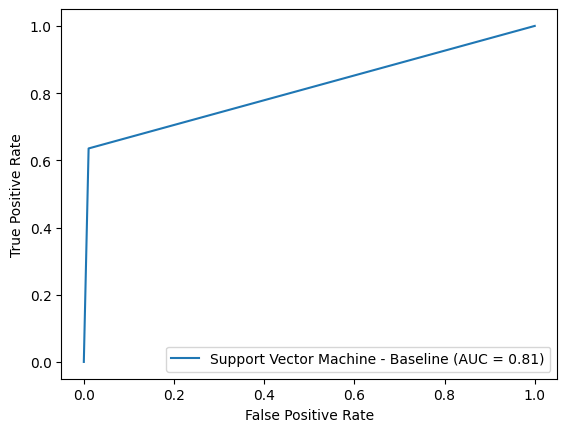

In [52]:
from sklearn.svm import LinearSVC
pipe = Pipeline([
    ('vectorize', training_vectorizer), 
    ('clf', LinearSVC())
    ]) 
pipe.fit(X_train['description'].values.astype('U'), y_train)
svm_baseline_pred = pipe.predict(X_test['description'].values.astype('U'))
print(classification_report(y_test, svm_baseline_pred))
display_roc_curve(y_test, svm_baseline_pred, "Support Vector Machine - Baseline")

# Oversampling/Undersampling 

Processing the text descriptions before applying oversampling or undersampling techniques.

In [53]:
X_test = training_vectorizer.transform(X_test['description'].values.astype('U'))
X_train = training_vectorizer.transform(X_train['description'].values.astype('U'))

### SMOTE

In [54]:
# Oversampling the dataset with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)
# Printing the number of samples of each class
print("The total number of fraudulent job ads are ", sum(y_smote_train == 1))
print("The total number of no fraudulent job ads are ", sum(y_smote_train == 0))

The total number of fraudulent job ads are  13619
The total number of no fraudulent job ads are  13619


#### Naive Bayes Classifier - SMOTE

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      3395
           1       0.20      0.66      0.30       181

    accuracy                           0.85      3576
   macro avg       0.59      0.76      0.61      3576
weighted avg       0.94      0.85      0.88      3576



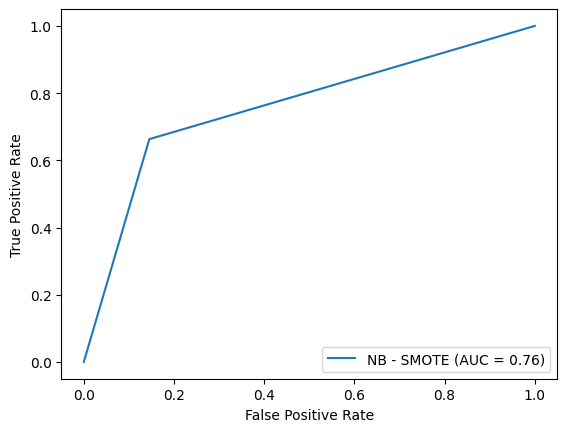

In [55]:
pipeline = Pipeline([
    ('classifier', BernoulliNB())
])

pipeline.fit(X_smote_train, y_smote_train)
naive_smote_pred = pipeline.predict(X_test)
print(classification_report(y_test, naive_smote_pred))
display_roc_curve(y_test, naive_smote_pred, "NB - SMOTE")

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      3395
           1       0.20      0.66      0.30       181

    accuracy                           0.85      3576
   macro avg       0.59      0.76      0.61      3576
weighted avg       0.94      0.85      0.88      3576



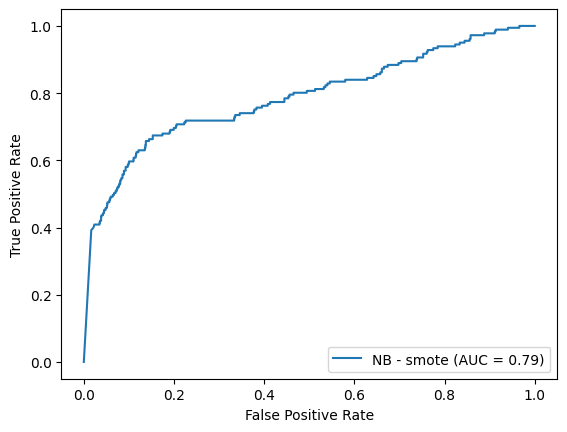

In [56]:
nb_pipeline = Pipeline([
    ('classifier', BernoulliNB())
])
nb_pipeline.fit(X_smote_train, y_smote_train)
nb_ns_pred = nb_pipeline.predict(X_test)
print(classification_report(y_test, nb_ns_pred))
y_proba_ns = nb_pipeline.predict_proba(X_test)[:, 1]
display_roc_curve(y_test, y_proba_ns, "NB - smote")

#### Logistic Regression - SMOTE

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3395
           1       0.47      0.69      0.56       181

    accuracy                           0.95      3576
   macro avg       0.73      0.82      0.77      3576
weighted avg       0.96      0.95      0.95      3576



c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


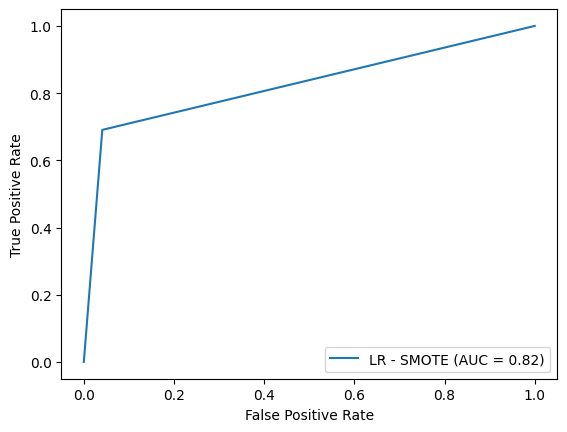

In [57]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('classifier', LogisticRegression()) 
])
pipeline.fit(X_smote_train, y_smote_train)
logreg_smote_pred = pipeline.predict(X_test)
print(classification_report(y_test, logreg_smote_pred))
display_roc_curve(y_test, logreg_smote_pred, "LR - SMOTE")

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3395
           1       0.47      0.69      0.56       181

    accuracy                           0.95      3576
   macro avg       0.73      0.82      0.77      3576
weighted avg       0.96      0.95      0.95      3576



c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


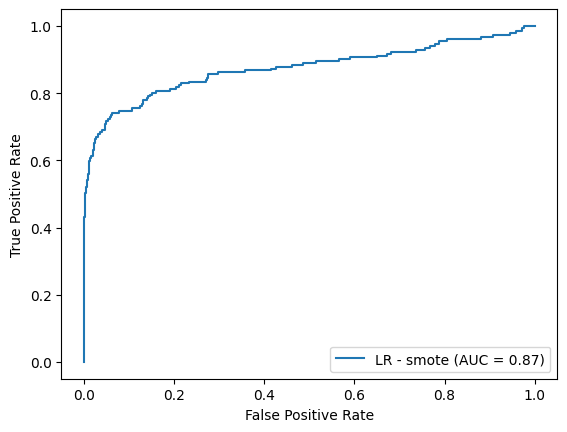

In [58]:
lr_pipeline = Pipeline([
    ('classifier', LogisticRegression())
])
lr_pipeline.fit(X_smote_train, y_smote_train)
lr_ns_pred = lr_pipeline.predict(X_test)
print(classification_report(y_test, lr_ns_pred))
y_proba_lr_ns = lr_pipeline.predict_proba(X_test)[:, 1]
display_roc_curve(y_test, y_proba_lr_ns, "LR - smote")

 #### Decision Trees - SMOTE

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3395
           1       0.45      0.65      0.53       181

    accuracy                           0.94      3576
   macro avg       0.71      0.80      0.75      3576
weighted avg       0.95      0.94      0.95      3576



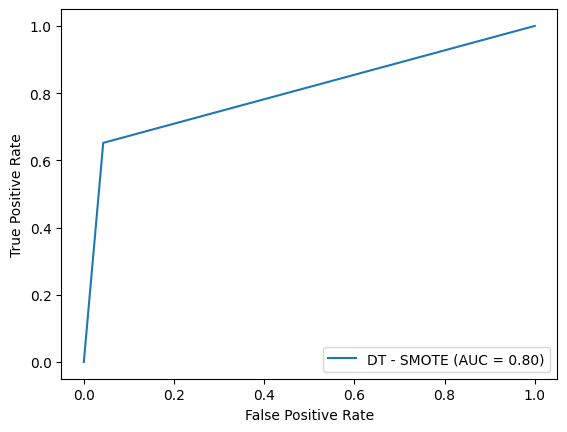

In [59]:
pipeline = Pipeline([
    ('classifier', tree.DecisionTreeClassifier())  
])
pipeline.fit(X_smote_train, y_smote_train)
dectrees_smote_pred = pipeline.predict(X_test)
print(classification_report(y_test, dectrees_smote_pred))
display_roc_curve(y_test, dectrees_smote_pred, "DT - SMOTE")

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3395
           1       0.43      0.65      0.52       181

    accuracy                           0.94      3576
   macro avg       0.71      0.80      0.74      3576
weighted avg       0.95      0.94      0.94      3576



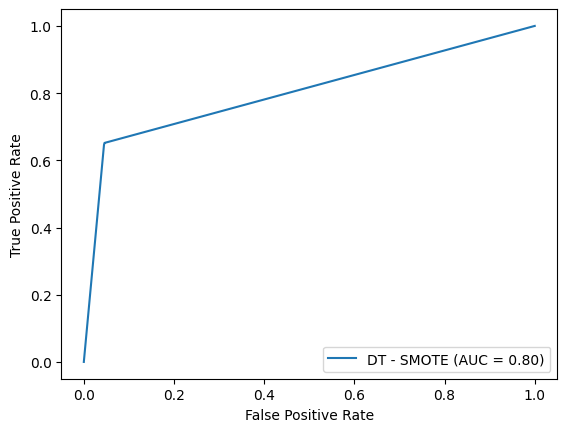

In [60]:
dt_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier())
])
dt_pipeline.fit(X_smote_train, y_smote_train)
dt_ns_pred = dt_pipeline.predict(X_test)
print(classification_report(y_test, dt_ns_pred))
y_proba_dt_ns = dt_pipeline.predict_proba(X_test)[:, 1]
display_roc_curve(y_test, y_proba_dt_ns, "DT - SMOTE")

#### Support Vector Machine - SMOTE


In [61]:
pipe = Pipeline([ 
                 ('clf', LinearSVC())
]) 

pipeline.fit(X_train, y_train)
svm_smote_pred = pipe.predict(X_test)
print(classification_report(y_test, svm_smote_pred))
display_roc_curve(y_test, svm_smote_pred, "SVM - SMOTE")

NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
svm_pipeline = Pipeline([
    ('classifier', SVC(probability=True))
])
svm_pipeline.fit(X_smote_train, y_smote_train)
svm_ns_pred = svm_pipeline.predict(X_test)
print(classification_report(y_test, svm_ns_pred))
y_proba_svm_ns = svm_pipeline.predict_proba(X_test)[:, 1]
display_roc_curve(y_test, y_proba_svm_ns, "SVM - SMOTE")


### NearMiss

I've decided to display both probability-based and linear visualizations to gain a deeper insight into the results, thus enabling performance optimization if necessary

In [ ]:
# Undersampling the dataset with NearMiss

near_miss = NearMiss()
X_ns_train, y_ns_train = near_miss.fit_resample(X_train, y_train)

# Printing the number of samples of each class
print("The total number of fraudulent job ads are ", sum(y_ns_train == 1))
print("The total number of no fraudulent job ads are ", sum(y_ns_train == 0))

#### Naive Bayes Classifier - NEAR MISS

In [ ]:
nb_pipeline = Pipeline([
    ('classifier', BernoulliNB())
])
nb_pipeline.fit(X_ns_train, y_ns_train)
nb_ns_pred = nb_pipeline.predict(X_test)
print(classification_report(y_test, nb_ns_pred))
display_roc_curve(y_test, nb_ns_pred, "NB - NearMiss")

In [ ]:
nb_pipeline = Pipeline([
    ('classifier', BernoulliNB())
])
nb_pipeline.fit(X_ns_train, y_ns_train)
nb_ns_pred = nb_pipeline.predict(X_test)
print(classification_report(y_test, nb_ns_pred))
y_proba_ns = nb_pipeline.predict_proba(X_test)[:, 1]
display_roc_curve(y_test, y_proba_ns, "NB - NearMiss")


#### Logistic Regression - NEAR MISS

In [ ]:
lr_pipeline = Pipeline([
    ('classifier', LogisticRegression())
])
lr_pipeline.fit(X_ns_train, y_ns_train)
lr_ns_pred = lr_pipeline.predict(X_test)
print(classification_report(y_test, lr_ns_pred))
display_roc_curve(y_test, lr_ns_pred, "LR - NearMiss")

In [ ]:
lr_pipeline = Pipeline([
    ('classifier', LogisticRegression())
])
lr_pipeline.fit(X_ns_train, y_ns_train)
lr_ns_pred = lr_pipeline.predict(X_test)
print(classification_report(y_test, lr_ns_pred))
y_proba_lr_ns = lr_pipeline.predict_proba(X_test)[:, 1]
display_roc_curve(y_test, y_proba_lr_ns, "LR - NearMiss")


#### Decision Trees - NEAR MISS

In [ ]:
dt_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier())
])
dt_pipeline.fit(X_ns_train, y_ns_train)
dt_ns_pred = dt_pipeline.predict(X_test)
print(classification_report(y_test, dt_ns_pred))
display_roc_curve(y_test, dt_ns_pred, "DT - NearMiss")

In [ ]:
dt_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier())
])
dt_pipeline.fit(X_ns_train, y_ns_train)
dt_ns_pred = dt_pipeline.predict(X_test)
print(classification_report(y_test, dt_ns_pred))
y_proba_dt_ns = dt_pipeline.predict_proba(X_test)[:, 1]
display_roc_curve(y_test, y_proba_dt_ns, "DT - NearMiss")


#### Support Vector Machine - NEAR MISS

In [ ]:
svm_pipeline = Pipeline([
    ('classifier', SVC(probability=True))
])
svm_pipeline.fit(X_ns_train, y_ns_train)
svm_ns_pred = svm_pipeline.predict(X_test)
print(classification_report(y_test, svm_ns_pred))
display_roc_curve(y_test, svm_ns_pred, "SVM - NearMiss")

In [ ]:
svm_pipeline = Pipeline([
    ('classifier', SVC(probability=True))
])
svm_pipeline.fit(X_ns_train, y_ns_train)
svm_ns_pred = svm_pipeline.predict(X_test)
print(classification_report(y_test, svm_ns_pred))
y_proba_svm_ns = svm_pipeline.predict_proba(X_test)[:, 1]
display_roc_curve(y_test, y_proba_svm_ns, "SVM - NearMiss")
